# Lab session 6: Deep Learning for Graphs (2/2)

## Learning objeftif

In this lab, you will learn about neural networks that operate on graphs. These models can be employed for addressing various tasks such as node classification, graph classification and link prediction. The lab is divided into two parts. In the first part, you will implement a graph neural network which belongs to the family of message passing models. The message passing layers of the model that will be implemented employs a self-attention mechanim that allows nodes to attend to their most important neighbors. The model will be evaluated in a graph classification task. 

In the second part, you will implement a graph neural network that operates at the graph level, and the model will be evaluated in a graph classification task. The two models will be implemented in Python, and we will use the following two libraries: (1) PyTorch (https://pytorch.org/), and (2) NetworkX
(http://networkx.github.io/).

## Imports

In [1]:
!pip install --upgrade scipy networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.8 MB 261 kB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import scipy.linalg as sci

import time
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from random import randint

import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from torch import optim

import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/MVA/ALTEGRAD/labs/lab6/code')

Mounted at /content/drive/


## Utils

In [3]:
def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

# Part 1: Graph Attention Network for Node-Level Tasks

In the first part of the lab, we will implement a graph neural network (GNN), and use it to classify the nodes of a small benchmark graph. Let A be the adjacency matrix of a graph G = (V, E) and X its feature matrix. For attributed graphs, these features may be set equal to the attribute vectors
of the nodes. For instance, in biology, proteins are represented as graphs where nodes correspond to secondary structure elements and the feature vector of each secondary structure element contains its physical properties. For graphs without node labels and node attributes, these vectors can either be random or can be initialized with a collection of local vertex features that are invariant to vertex renumbering (e.g., degree). 

A standard GNN model takes the matrices A and X as input and learns a hidden representation for each node.
Most GNN models update the representation of each node by aggregating the feature vectors of its neighbors. **This update procedure can be viewed as a form of message passing algorithm**. Different types of message passing layers have been proposed in the past years. Recently, a lot of interest has
been devoted to layers that compute the hidden representation of each node in the graph by attending over its neighbors. This allows a node to selectively attend to specific neighbors while ignoring
others. We will next implement such a message passing layer which follows a self-attention strategy to update the representations of the nodes.

## Implementation of Graph Attention Layer

### task 1

In [89]:
class GATLayer(nn.Module):
    """GAT layer"""
    def __init__(self, n_feat, n_hidden, alpha=0.05):
        super(GATLayer, self).__init__()
        self.n_hidden=n_hidden
        self.fc = nn.Linear(n_feat, n_hidden, bias=False)
        self.a = nn.Linear(2*n_hidden, 1)
        self.leakyrelu = nn.LeakyReLU(alpha)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, adj):
        
        ############## Task 1
    
        ##################
        #compute h 
        N = x.shape[0]
        h_prime=self.fc(x).view(N, self.n_hidden)
        a_input = torch.cat([h_prime.repeat(N, 1), h_prime.repeat_interleave(N, dim=0)], dim=1).view(N,N, 2*self.n_hidden)

        e   = self.leakyrelu(self.a(a_input)).squeeze(-1)
        e = e.masked_fill(adj == 0, float('-inf'))
        a = self.softmax(e)
        attn_res = torch.einsum('ij,jf->if', a, h_prime)
        
        
        
        ##################

        #h = torch.exp(h.squeeze())
        #unique = torch.unique(indices[0,:])
        #t = torch.zeros(unique.size(0), device=x.device)
        
        #h_sum = t.scatter_add(0, indices[0,:], h )
        #h_norm = torch.gather(h_sum, 0, indices[0,:])
        #alpha = torch.div(h, h_norm)
        #adj_att = torch.sparse.FloatTensor(indices, alpha, torch.Size([x.size(0), x.size(0)])).to(x.device)
        
        ##################
        #a_dot_t = (adj * adj_att)
        out=attn_res
        ##################

        return out, a




## Implementation of Graph Neural Network

### task 2 + task 4

In [5]:
class GNN(nn.Module):
    """GNN model"""
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GNN, self).__init__()
        self.mp1 = GATLayer(nfeat, nhid)
        self.mp2 = GATLayer(nhid, nhid)
        self.fc = nn.Linear(nhid, nclass)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x, adj):
        
        ############## Tasks 2 and 4
    
        ##################
        x,_=self.mp1(x,adj)
        x=self.relu(x)
        x=self.dropout(x)
        x,alpha=self.mp2(x,adj)
        x=self.relu(x)

        x=self.fc(x)
        ##################

        return F.log_softmax(x, dim=1), alpha

## Node Classification

### task 3

In [6]:
# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
n_hidden = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('./data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

n = G.number_of_nodes()



Number of nodes: 34
Number of edges: 78


In [7]:
# Loads the class labels
class_labels = np.loadtxt('./data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

In [8]:
############## Task 3
adj =nx.adjacency_matrix(G).todense() # your code here #
features = np.random.randn(n, n_class)# your code here #

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
#adj = sparse_to_torch_sparse(adj).to(device)
adj=torch.FloatTensor(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train model
for epoch in range(epochs):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)[0]
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))

print("Optimization Finished!")

# Testing
model.eval()
output = model(features, adj)[0]
loss_test = F.nll_loss(output[idx_test], y[idx_test])
acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
print("Test set results:",
      "loss= {:.4f}".format(loss_test.item()),
      "accuracy= {:.4f}".format(acc_test))


<ipython-input-8-9997bb8f18ba>:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj =nx.adjacency_matrix(G).todense() # your code here #


Epoch: 001 loss_train: 0.6898 acc_train: 0.5556 time: 0.1823s
Epoch: 002 loss_train: 0.6863 acc_train: 0.5556 time: 0.0066s
Epoch: 003 loss_train: 0.6859 acc_train: 0.5556 time: 0.0053s
Epoch: 004 loss_train: 0.6815 acc_train: 0.5556 time: 0.0063s
Epoch: 005 loss_train: 0.6801 acc_train: 0.5556 time: 0.0051s
Epoch: 006 loss_train: 0.6826 acc_train: 0.5556 time: 0.0045s
Epoch: 007 loss_train: 0.6792 acc_train: 0.5556 time: 0.0080s
Epoch: 008 loss_train: 0.6737 acc_train: 0.5556 time: 0.0088s
Epoch: 009 loss_train: 0.6714 acc_train: 0.5556 time: 0.0059s
Epoch: 010 loss_train: 0.6702 acc_train: 0.5556 time: 0.0042s
Epoch: 011 loss_train: 0.6609 acc_train: 0.5556 time: 0.0048s
Epoch: 012 loss_train: 0.6612 acc_train: 0.5556 time: 0.0063s
Epoch: 013 loss_train: 0.6587 acc_train: 0.5926 time: 0.0061s
Epoch: 014 loss_train: 0.6542 acc_train: 0.5926 time: 0.0057s
Epoch: 015 loss_train: 0.6461 acc_train: 0.6667 time: 0.0041s
Epoch: 016 loss_train: 0.6366 acc_train: 0.6667 time: 0.0043s
Epoch: 0

### task 4

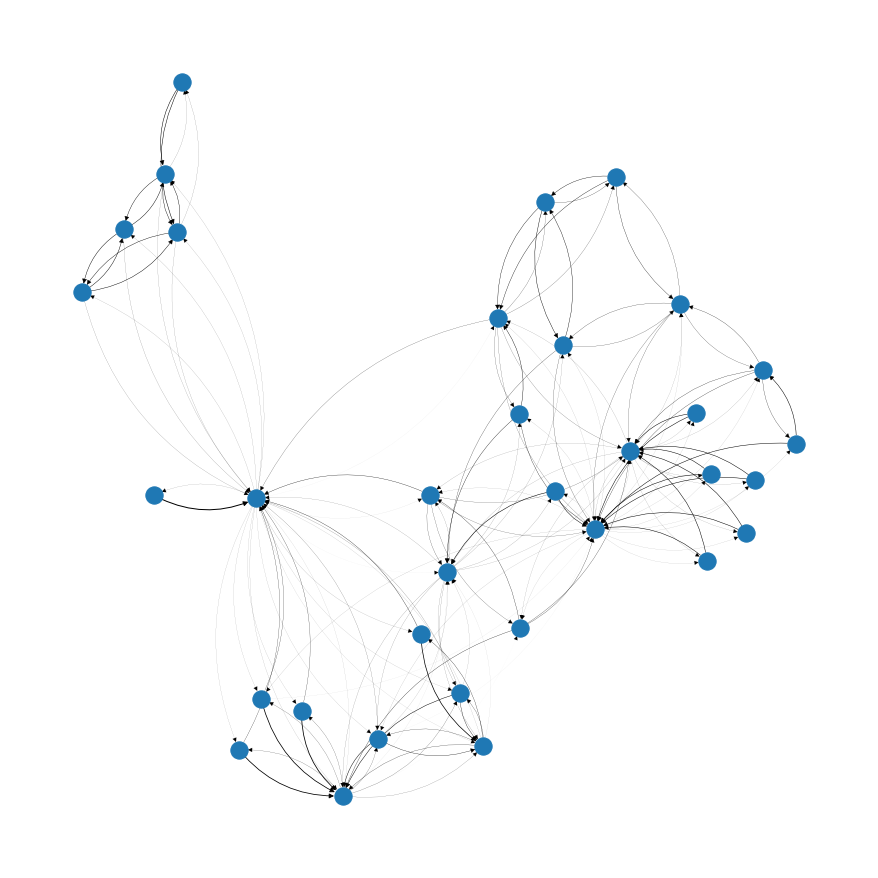

In [9]:

############## Task 4
alpha = model(features, adj)[1]# your code here 
alpha=alpha.detach().cpu().numpy()
# Dictionary that maps indices of nodes to nodes
idx_to_node = dict()
for i,node in enumerate(G.nodes()):
    idx_to_node[i] = node

# Creates a directed karate network
G_directed = G.to_directed()

# Retrieves nonzero indices of the adjacency matrix
indices = np.where(adj!=0)

# Annotates edges with the learned attention weights 
for i in range(len(indices[1])):
    G_directed[idx_to_node[indices[0][i]]][idx_to_node[indices[1][i]]]['weight'] = alpha[indices[0][i],indices[1][i]]

weights = [G_directed[u][v]['weight'] for u,v in G_directed.edges()]

# Visualizes attention weights
plt.figure(1,figsize=(12,12))
pos = nx.spring_layout(G_directed)
arc_rad = 0.25
nx.draw(G_directed, width=weights, connectionstyle=f'arc3, rad = {arc_rad}')
plt.show()

# Part 2: Graph Neural Networks for Graph-Level Tasks

## Dataset Generation

### task 5

In [65]:
def create_dataset():
    Gs = list()
    y = list()

    ############## Task 5
    
    ##################
    for _ in range(50): 
      #first class
      n=randint(10,20)
      p=0.2
      G=nx.fast_gnp_random_graph(n,p)
      Gs.append(G)
      y.append(1)
      #second_class
      n=randint(10,20)
      p=0.4
      G=nx.fast_gnp_random_graph(n,p)
      Gs.append(G)
      y.append(2)
    ##################

    return Gs, y

## Implementation of Graph Neural Network

### task 6

In [90]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, n_class, device):
        super(GNN, self).__init__()
        self.device = device
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, hidden_dim_3)
        self.fc4 = nn.Linear(hidden_dim_3, n_class)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj, idx):
        
        ############## Task 6
    
        ##################
        a_bar=torch.Tensor(adj+np.eye(adj.shape[0]))
        x=a_bar*x_in
        x=self.fc1(x_in)
        x=self.relu(x)
        x=torch.mm(a_bar,x)
        x=self.fc2(x)
        ##################
        
        idx = idx.unsqueeze(1).repeat(1, x.size(1))
        out = torch.zeros(torch.max(idx)+1, x.size(1)).to(self.device)
        out = out.scatter_add_(0, idx, x) 
        
        ##################
        out=self.fc3(out)
        out=self.relu(out)
        out=self.fc4(out)
        out=self.relu(out)
        ##################

        return F.log_softmax(out, dim=1)


## Graph Classification

### task 7

In [76]:
# Initializes device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 200
batch_size = 8
n_hidden_1 = 16
n_hidden_2 = 32
n_hidden_3 = 32
learning_rate = 0.01

# Generates synthetic dataset
Gs, y = create_dataset()
n_class = np.unique(y).size

# Splits the dataset into a training and a test set
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

N_train = len(G_train)
N_test = len(G_test)

# Initializes model and optimizer
model = GNN(1, n_hidden_1, n_hidden_2, n_hidden_3, n_class, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()


In [91]:
from numpy.core.memmap import uint8
import random
# Trains the model
for epoch in range(epochs):
    t = time.time()
    model.train()
    
    train_loss = 0
    correct = 0
    count = 0
    for i in range(0, N_train, batch_size):
        adj_batch = list()
        idx_batch = list()
        y_batch = list()
        features_batch=list()
        ############## Task 7
        
        ##################
        # your code here #
        batch=random.sample(range(0, N_train), batch_size)
        for i in batch:
          G=G_train[i]
          if adj_batch==[]:
            adj_batch=sci.block_diag(np.array(nx.adjacency_matrix(G,dtype=uint8).todense()))
          else:
            adj_batch=sci.block_diag(adj_batch,np.array(nx.adjacency_matrix(G,dtype=uint8).todense()))
          
          idx_batch+=[i]*G.number_of_nodes()
          features_batch+=[[1]]*G.number_of_nodes()
          y_batch.append(y_train[i])
          
        ##################
        adj_batch=torch.Tensor(adj_batch).to(device)

        features_batch=torch.FloatTensor(features_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)
        idx_batch=torch.LongTensor(idx_batch).to(device)


        optimizer.zero_grad()
        output = model(features_batch, adj_batch, idx_batch)
        loss = loss_function(output, y_batch)
        train_loss += loss.item() * output.size(0)
        count += output.size(0)
        preds = output.max(1)[1].type_as(y_batch)
        correct += torch.sum(preds.eq(y_batch).double())
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        print('Epoch: {:04d}'.format(epoch+1),
              'loss_train: {:.4f}'.format(train_loss / count),
              'acc_train: {:.4f}'.format(correct / count),
              'time: {:.4f}s'.format(time.time() - t))
        
print('Optimization finished!')



<ipython-input-91-58a2bde6df08>:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_batch=sci.block_diag(np.array(nx.adjacency_matrix(G,dtype=uint8).todense()))
<ipython-input-91-58a2bde6df08>:23: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if adj_batch==[]:
<ipython-input-91-58a2bde6df08>:26: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_batch=sci.block_diag(adj_batch,np.array(nx.adjacency_matrix(G,dtype=uint8).todense()))


RuntimeError: ignored

In [ ]:
# Evaluates the model
model.eval()
test_loss = 0
correct = 0
count = 0
for i in range(0, N_test, batch_size):
    adj_batch = list()
    idx_batch = list()
    y_batch = list()

    ############## Task 7
    
    ##################
    # your code here #
    ##################

    output = model(features_batch, adj_batch, idx_batch)
    loss = loss_function(output, y_batch)
    test_loss += loss.item() * output.size(0)
    count += output.size(0)
    preds = output.max(1)[1].type_as(y_batch)
    correct += torch.sum(preds.eq(y_batch).double())

print('loss_test: {:.4f}'.format(test_loss / count),
      'acc_test: {:.4f}'.format(correct / count),
      'time: {:.4f}s'.format(time.time() - t))
